# Investigating which areas show significant second level effects at which times

In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import source_visualisations as sv
import mne

## Data preparation
Which data?

In [2]:
# baseline [-0.3, 0], trialregs_dot=5
# basefile = 'source_HCPMMP1_allsubs_201703301614.h5'

# baseline None, trialregs_dot=5
#basefile = 'source_HCPMMP1_allsubs_201706091054.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space
#basefile = 'source_sequential_201706141650.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space, move_dist, sum_dot_y
#basefile = 'source_sequential_201706191442.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space, move_dist, 
# sum_dot_y, constregs=0 for 1st dot
basefile = 'source_sequential_201706201654.h5'

choose measure and identify threshold

In [3]:
# e.g.: mu_p_large, mu_testval, mu_t, mu_mean
measure = 'mu_testval'

# which regressors should define the empirical value distribution?
# set regressors = None for all
regressors = ['dot_x', 'dot_y', 'abs_dot_x', 'abs_dot_y', 'move_dist']

# do not use these regressors to define empirical value distribution
exclude = 'trialregs'

# the empiric error threshold for a single time point and area
# (the selected threshold will be the quantile 1-alpha of the 
# empirical distribution of measure values)
alpha = 0.05

threshold, measure_cdf = sv.find_slabs_threshold(
    basefile, measure, quantile=1-alpha, regressors=regressors, 
    exclude=exclude, verbose=1, return_cdf=True)

print('\nthreshold = {:.4f}'.format(threshold))

excluding:
intercept
entropy
response
trial_time

adding abs_dot_x
adding abs_dot_y
adding dot_x
adding dot_y
adding move_dist
N = 90500

threshold = 0.0002


what are large values for the possible measures (used for setting y-lim in plotting)

In [4]:
ylims = {'mu_p_large': 1, 'mu_t': 8, 'mu_z': 8, 'mu_testval': 0.02, 'mu_mean': 0.8}
logy = {'mu_p_large': False, 'mu_t': False, 'mu_z': False, 'mu_testval': True, 'mu_mean': False}

## Load data for all selected regressors and identify significant clusters in time
The idea is that you identify sequences of high measure values that cannot happen by chance. This is all based on the empirical measure distribution used above. This distribution defines the probability with which I would get a particular measure value, if I were to draw one randomly across locations, time points and regressors. So it is a permutation distribution. I then use the cumulative density function of this distribution to first select a cluster threshold, i.e., a measure value which has to be exceeded in order to form a sequence cluster. Then I identify clusters, i.e., sequences of measure values within an area that exceed the threshold. The p-value of the found cluster is the product of 1-cdf(value) for the measure values in the sequence.

In [5]:
clusters = []
for r_name in regressors:
    srcfile = basefile[:-3] + '_slabs_%s.h5' % r_name
    file = 'mne_subjects/fsaverage/bem/' + srcfile
    src_df = pd.read_hdf(file, 'second_level_src')
    clusters.append(sv.get_time_clusters(src_df[measure], threshold, measure_cdf))

clusters = pd.concat(clusters, keys=regressors, names=['regressor', 'cluster'])

now FDR-correct the found clusters

In [6]:
cluster_alpha = 0.001
reject, pval = mne.stats.fdr_correction(10**clusters.log10p, cluster_alpha)
clusters['pval_corrected'] = pval
clusters = clusters[reject]

# add region of area for information
def get_region(area):
    if area.startswith('??'):
        section = 'whole hemisphere'
    else:
        section = sv.Glasser_areas[sv.Glasser_areas['area name'] == area[2:-7]]['main section']
        section = sv.Glasser_sections.loc[section].name.values[0]
    
    return section
clusters['region'] = clusters.label.apply(get_region)

clusters

label  start_t  end_t     log10p  pval_corrected  \
regressor cluster                                                              
dot_x     0                ???-lh      410    450  -7.616427    4.007153e-07   
          1                ???-lh      470    490  -5.013402    8.645710e-05   
          4                ???-rh      410    430  -5.278230    5.125788e-05   
          5            L_1_ROI-lh      320    490 -33.869123    2.169460e-32   
          10         L_23d_ROI-lh      470    490  -6.082864    1.004028e-05   
          13        L_24dd_ROI-lh      400    420  -5.225229    5.704683e-05   
          14        L_24dd_ROI-lh      440    490 -14.345062    1.933669e-13   
          16        L_24dv_ROI-lh      290    320  -6.574870    3.559788e-06   
          17        L_24dv_ROI-lh      380    490 -33.252358    7.747834e-32   
          18           L_2_ROI-lh      160    180  -6.679687    2.871218e-06   
          20           L_2_ROI-lh      400    430  -8.923281    2.471110e-08   
          21           L_2_ROI-lh      450    490 -10.332485    1.206353e-09   
          23         L_31a_ROI-lh      400    410  -3.921933    7.589395e-04   
          29        L_31pd_ROI-lh      300    360 -16.198792    3.249623e-15   
          30        L_31pd_ROI-lh      380    480 -24.321589    3.826977e-23   
          32        L_31pv_ROI-lh      290    340 -12.987293    3.832241e-12   
          33        L_31pv_ROI-lh      360    490 -29.750406    2.073799e-28   
          35        L_33pr_ROI-lh      300    350 -10.087683    2.017803e-09   
          37        L_33pr_ROI-lh      400    490 -27.868716    1.389758e-26   
          39          L_3a_ROI-lh      330    490 -34.300217    9.188618e-33   
          41          L_3b_ROI-lh      320    490 -38.892184    4.114542e-37   
          46          L_45_ROI-lh      460    490  -6.081513    1.004028e-05   
          50           L_4_ROI-lh      310    330  -6.035118    1.101638e-05   
          51           L_4_ROI-lh      350    490 -33.018646    1.230040e-31   
          52          L_52_ROI-lh      310    330  -4.790037    1.374406e-04   
          57          L_5L_ROI-lh      250    330 -16.851715    7.854573e-16   
          61         L_5mv_ROI-lh      150    180  -6.512157    4.049516e-06   
          63         L_5mv_ROI-lh      320    340  -4.495902    2.432556e-04   
          67          L_6a_ROI-lh      390    490 -21.943822    8.118408e-21   
          69          L_6d_ROI-lh      350    490 -37.679024    5.377380e-36   
...                           ...      ...    ...        ...             ...   
move_dist 262        R_23c_ROI-rh      340    370  -6.477664    4.339748e-06   
          269       R_24dd_ROI-rh      270    290  -4.698874    1.630838e-04   
          272       R_24dd_ROI-rh      470    490  -5.839193    1.635395e-05   
          284        R_31a_ROI-rh      340    350  -3.899014    7.922417e-04   
          287       R_31pd_ROI-rh      110    130  -4.460886    2.539653e-04   
          290       R_31pv_ROI-rh      100    130  -8.043402    1.602601e-07   
          318         R_6r_ROI-rh      400    470 -11.948204    3.403867e-11   
          334         R_9m_ROI-rh        0     10  -3.977213    6.834188e-04   
          339         R_A4_ROI-rh      450    470  -4.781235    1.397934e-04   
          352        R_DVT_ROI-rh       90    140 -12.448312    1.172703e-11   
          379        R_IP0_ROI-rh      170    190  -4.304536    3.442367e-04   
          380        R_IP1_ROI-rh      100    130  -6.339709    5.814797e-06   
          387       R_IPS1_ROI-rh       90    120  -7.878704    2.278793e-07   
          394      R_LBelt_ROI-rh      480    490  -3.903452    7.861090e-04   
          395       R_LIPd_ROI-rh        0     50 -11.634230    6.932124e-11   
          396       R_LIPd_ROI-rh       90    140 -12.005311    3.019988e-11   
          448       R_PoI1_ROI-rh      390    420  -6.771717    2.373704e-06   
          453       R_ProS_R

## Find all clusters of a given area or region

In [7]:
area = 'v23ab'
clusters[clusters.label.apply(lambda s: s.find(area) >= 0)]

label  start_t  end_t     log10p  pval_corrected  \
regressor cluster                                                              
dot_x     357      L_v23ab_ROI-lh      110    130  -7.608725    4.052707e-07   
          358      L_v23ab_ROI-lh      150    200 -10.412231    1.024689e-09   
          359      L_v23ab_ROI-lh      300    360 -19.324062    3.122254e-18   
          360      L_v23ab_ROI-lh      380    490 -33.241661    7.747834e-32   
          743      R_v23ab_ROI-rh      100    120  -7.640359    3.841891e-07   
          744      R_v23ab_ROI-rh      150    180  -6.648042    3.055564e-06   
          745      R_v23ab_ROI-rh      200    220  -4.328264    3.322188e-04   
          746      R_v23ab_ROI-rh      300    490 -57.413488    9.910766e-55   
abs_dot_x 220      L_v23ab_ROI-lh       70    100  -6.754341    2.457175e-06   
          481      R_v23ab_ROI-rh       70    130 -13.251135    2.149734e-12   
abs_dot_y 194      L_v23ab_ROI-lh      180    210  -6.044697    1.087724e-05   
          381      R_v23ab_ROI-rh      180    220  -7.256970    8.665261e-07   
          382      R_v23ab_ROI-rh      290    310  -5.120428    7.000397e-05   
move_dist 550      R_v23ab_ROI-rh       80    140 -13.020145    3.605296e-12   

                                       region  
regressor cluster                              
dot_x     357      posterior cingulate cortex  
          358      posterior cingulate cortex  
          359      posterior cingulate cortex  
          360      posterior cingulate cortex  
          743      posterior cingulate cortex  
          744      posterior cingulate cortex  
          745      posterior cingulate cortex  
          746      posterior cingulate cortex  
abs_dot_x 220      posterior cingulate cortex  
          481      posterior cingulate cortex  
abs_dot_y 194      posterior cingulate cortex  
          381      posterior cingulate cortex  
          382      posterior cingulate cortex  
move_dist 550      posterior cingulate cortex

In [8]:
region = 'dorsolat'
clusters[clusters.region.apply(lambda s: s.find(region) >= 0)]

label  start_t  end_t     log10p  pval_corrected  \
regressor cluster                                                             
dot_x     477        R_8C_ROI-rh      310    360 -11.488797    9.469252e-11   
          478        R_8C_ROI-rh      400    420  -4.521382    2.326539e-04   
          726      R_i6-8_ROI-rh      400    420  -6.036425    1.101638e-05   
          727      R_i6-8_ROI-rh      440    470  -8.276572    1.006210e-07   
          742      R_s6-8_ROI-rh      460    480  -5.451639    3.616447e-05   
abs_dot_x 274       R_8Av_ROI-rh      340    360  -5.413419    3.933465e-05   
abs_dot_y 245       R_8Av_ROI-rh      180    200  -4.473336    2.517473e-04   

                                           region  
regressor cluster                                  
dot_x     477      dorsolateral prefrontal cortex  
          478      dorsolateral prefrontal cortex  
          726      dorsolateral prefrontal cortex  
          727      dorsolateral prefrontal cortex  
          742      dorsolateral prefrontal cortex  
abs_dot_x 274      dorsolateral prefrontal cortex  
abs_dot_y 245      dorsolateral prefrontal cortex

## Investigate individual regressors

In [9]:
r_name = 'dot_x'
r_clusters = clusters.xs(r_name, level='regressor')

srcfile = basefile[:-3] + '_slabs_%s.h5' % r_name
file = 'mne_subjects/fsaverage/bem/' + srcfile
src_df = pd.read_hdf(file, 'second_level_src')

### Check the times at which we see significant clusters

<IPython.core.display.Javascript object>


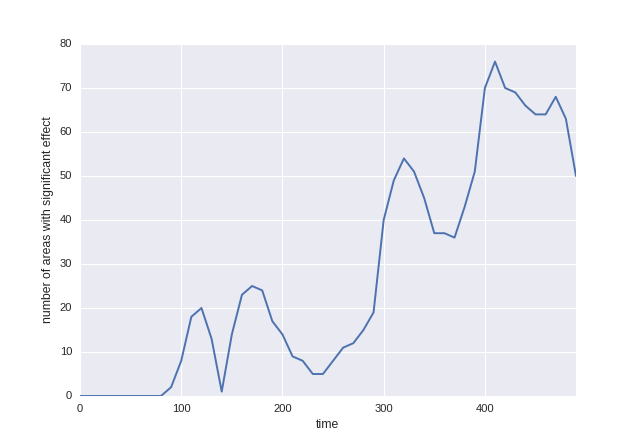

In [10]:
times = src_df[measure].index.levels[1]
sigareas = r_clusters.label.unique()
significant = pd.DataFrame(np.zeros((sigareas.size, times.size), bool), 
                           index=sigareas, columns=times)
for row in r_clusters.itertuples():
    significant.loc[row.label, slice(row.start_t, row.end_t)] = True
    
fig, ax = plt.subplots()
significant.sum().plot();
ax.set_ylabel('number of areas with significant effect');

### Identify areas

In [11]:
def get_areas(times):
    if type(times) is not list:
        times = [times]
    
    return significant[np.all(significant[times], axis=1)].index

def active_areas(times, times2=None):
    """Returns areas that are reliably activated at all time points in times.
       If times2 is provided, intersection and set differences of areas 
       associated with times and times2 are indicated."""
    
    print(r_name)
    
    areas = get_areas(times)
    
    if times2 is None:
        areas2 = pd.Index([])
    else:
        areas2 = get_areas(times2)
    
    areas = pd.concat([pd.Series(areas.difference(areas2)), 
                       pd.Series(areas.intersection(areas2)), 
                       pd.Series(areas2.difference(areas))],
                      keys=['only 1', 'intersect', 'only 2'])
    areas = pd.DataFrame(areas, columns=['area'])
    
    areas['region'] = areas.area.apply(get_region)
    
    return areas

In [12]:
active_areas(330, 410)

dot_x


area                                           region
only 1    0      L_52_ROI-lh             insular and frontal opercular cortex
          1      L_5L_ROI-lh     paracentral lobular and mid cingulate cortex
          2     L_5mv_ROI-lh     paracentral lobular and mid cingulate cortex
          3     L_PIT_ROI-lh                     ventral stream visual cortex
          4   L_TPOJ2_ROI-lh               temporo-parieto-occipital junction
          5    L_V3CD_ROI-lh         MT+ complex and neighboring visual areas
          6      L_V4_ROI-lh                              early visual cortex
          7     L_VIP_ROI-lh                         superior parietal cortex
          8    L_VMV3_ROI-lh                     ventral stream visual cortex
          9   L_a24pr_ROI-lh  anterior cingulate and medial prefrontal cortex
          10    R_5mv_ROI-rh     paracentral lobular and mid cingulate cortex
          11     R_6v_ROI-rh                                  premotor cortex
          12    R_7Pm_ROI-rh                         superior parietal cortex
          13    R_p24_ROI-rh  anterior cingulate and medial prefrontal cortex
intersect 0       L_1_ROI-lh                   somatosensory and motor cortex
          1    L_31pd_ROI-lh                       posterior cingulate cortex
          2    L_31pv_ROI-lh                       posterior cingulate cortex
          3    L_33pr_ROI-lh  anterior cingulate and medial prefrontal cortex
          4      L_3a_ROI-lh                   somatosensory and motor cortex
          5      L_3b_ROI-lh                   somatosensory and motor cortex
          6       L_4_ROI-lh                   somatosensory and motor cortex
          7      L_7m_ROI-lh                       posterior cingulate cortex
          8     L_FEF_ROI-lh                                  premotor cortex
          9     L_PCV_ROI-lh                       posterior cingulate cortex
          10   L_SCEF_ROI-lh     paracentral lobular and mid cingulate cortex
          11     L_V6_ROI-lh                      dorsal stream visual cortex
          12  L_d23ab_ROI-lh                       posterior cingulate cortex
          13  L_v23ab_ROI-lh                       posterior cingulate cortex
          14      R_1_ROI-rh                   somatosensory and motor cortex
          15   R_24dv_ROI-rh     paracentral lobular and mid cingulate cortex
...                      ...                                              ...
only 2    9     L_DVT_ROI-lh                       posterior cingulate cortex
          10    L_IP0_ROI-lh                         inferior parietal cortex
          11     L_Ig_ROI-lh             insular and frontal opercular cortex
          12   L_LIPd_ROI-lh                         superior parietal cortex
          13  L_MBelt_ROI-lh                            early auditory cortex
          14    L_MST_ROI-lh         MT+ complex and neighboring visual areas
          15    L_PGi_ROI-lh                         inferior parietal cortex
          16   L_PoI1_ROI-lh             insular and frontal opercular cortex
          17   L_ProS_ROI-lh                       posterior cingulate cortex
          18     L_RI_ROI-lh                            early auditory cortex
          19  L_TPOJ1_ROI-lh               temporo-parieto-occipital junction
          20  L_p32pr_ROI-lh  anterior cingulate and medial prefrontal cortex
          21      R_2_ROI-rh                   somatosensory and motor cortex
          22   R_33pr_ROI-rh  anterior cingulate and medial prefrontal cortex
          23     R_3a_ROI-rh                   somatosensory and motor cortex
          24     R_5L_ROI-rh     paracentral lobular and mid cingulate cortex
          25   R_AAIC_ROI-rh             insular and frontal opercular cortex
          26    R_DVT_ROI-rh                       posterior cingulate cortex
          27    R_FEF_ROI-rh                                  premotor cortex
          28    R_IP0_ROI-rh                  

In [13]:
active_areas(120, 170)

dot_x


area                                           region
only 1    0     L_LO3_ROI-lh         MT+ complex and neighboring visual areas
          1    L_ProS_ROI-lh                       posterior cingulate cortex
          2      L_RI_ROI-lh                            early auditory cortex
          3      L_V1_ROI-lh                            primary visual cortex
          4      L_V3_ROI-lh                              early visual cortex
          5    L_VMV2_ROI-lh                     ventral stream visual cortex
          6     L_VVC_ROI-lh                     ventral stream visual cortex
          7    R_33pr_ROI-rh  anterior cingulate and medial prefrontal cortex
          8     R_LO1_ROI-rh         MT+ complex and neighboring visual areas
          9    R_ProS_ROI-rh                       posterior cingulate cortex
          10     R_RI_ROI-rh                            early auditory cortex
          11   R_TE2p_ROI-rh                          lateral temporal cortex
          12  R_TPOJ3_ROI-rh               temporo-parieto-occipital junction
          13     R_V2_ROI-rh                              early visual cortex
          14     R_V3_ROI-rh                              early visual cortex
          15    R_V4t_ROI-rh         MT+ complex and neighboring visual areas
          16   R_VMV1_ROI-rh                     ventral stream visual cortex
intersect 0      L_V2_ROI-lh                              early visual cortex
          1   L_v23ab_ROI-lh                       posterior cingulate cortex
          2   R_v23ab_ROI-rh                       posterior cingulate cortex
only 2    0       L_2_ROI-lh                   somatosensory and motor cortex
          1     L_5mv_ROI-lh     paracentral lobular and mid cingulate cortex
          2     L_AIP_ROI-lh                         superior parietal cortex
          3     L_DVT_ROI-lh                       posterior cingulate cortex
          4     L_IP0_ROI-lh                         inferior parietal cortex
          5     L_IP1_ROI-lh                         inferior parietal cortex
          6    L_IPS1_ROI-lh                      dorsal stream visual cortex
          7     L_PCV_ROI-lh                       posterior cingulate cortex
          8    L_POS2_ROI-lh                       posterior cingulate cortex
          9     L_V3A_ROI-lh                      dorsal stream visual cortex
          10   L_V3CD_ROI-lh         MT+ complex and neighboring visual areas
          11    R_5mv_ROI-rh     paracentral lobular and mid cingulate cortex
          12    R_7Am_ROI-rh                         superior parietal cortex
          13    R_DVT_ROI-rh                       posterior cingulate cortex
          14    R_IP0_ROI-rh                         inferior parietal cortex
          15   R_IPS1_ROI-rh                      dorsal stream visual cortex
          16   R_LIPv_ROI-rh                         superior parietal cortex
          17   R_PFcm_ROI-rh                       posterior opercular cortex
          18    R_PGp_ROI-rh                         inferior parietal cortex
          19    R_STV_ROI-rh               temporo-parieto-occipital junction
          20    R_V6A_ROI-rh                      dorsal stream visual cortex
          21     R_V7_ROI-rh                      dorsal stream visual cortex

In [14]:
active_areas(170, 320)

dot_x


area                                           region
only 1    0       L_2_ROI-lh                   somatosensory and motor cortex
          1     L_AIP_ROI-lh                         superior parietal cortex
          2     L_DVT_ROI-lh                       posterior cingulate cortex
          3     L_IP0_ROI-lh                         inferior parietal cortex
          4     L_IP1_ROI-lh                         inferior parietal cortex
          5    L_IPS1_ROI-lh                      dorsal stream visual cortex
          6    L_POS2_ROI-lh                       posterior cingulate cortex
          7      L_V2_ROI-lh                              early visual cortex
          8     L_V3A_ROI-lh                      dorsal stream visual cortex
          9     R_5mv_ROI-rh     paracentral lobular and mid cingulate cortex
          10    R_7Am_ROI-rh                         superior parietal cortex
          11    R_DVT_ROI-rh                       posterior cingulate cortex
          12    R_IP0_ROI-rh                         inferior parietal cortex
          13   R_IPS1_ROI-rh                      dorsal stream visual cortex
          14   R_LIPv_ROI-rh                         superior parietal cortex
          15    R_PGp_ROI-rh                         inferior parietal cortex
          16    R_STV_ROI-rh               temporo-parieto-occipital junction
          17    R_V6A_ROI-rh                      dorsal stream visual cortex
          18     R_V7_ROI-rh                      dorsal stream visual cortex
intersect 0     L_5mv_ROI-lh     paracentral lobular and mid cingulate cortex
          1     L_PCV_ROI-lh                       posterior cingulate cortex
          2    L_V3CD_ROI-lh         MT+ complex and neighboring visual areas
          3   L_v23ab_ROI-lh                       posterior cingulate cortex
          4    R_PFcm_ROI-rh                       posterior opercular cortex
          5   R_v23ab_ROI-rh                       posterior cingulate cortex
only 2    0       L_1_ROI-lh                   somatosensory and motor cortex
          1    L_24dv_ROI-lh     paracentral lobular and mid cingulate cortex
          2    L_31pd_ROI-lh                       posterior cingulate cortex
          3    L_31pv_ROI-lh                       posterior cingulate cortex
          4    L_33pr_ROI-lh  anterior cingulate and medial prefrontal cortex
...                      ...                                              ...
          18     L_V4_ROI-lh                              early visual cortex
          19     L_V6_ROI-lh                      dorsal stream visual cortex
          20    L_VIP_ROI-lh                         superior parietal cortex
          21   L_VMV3_ROI-lh                     ventral stream visual cortex
          22  L_a24pr_ROI-lh  anterior cingulate and medial prefrontal cortex
          23  L_d23ab_ROI-lh                       posterior cingulate cortex
          24  L_p24pr_ROI-lh  anterior cingulate and medial prefrontal cortex
          25      R_1_ROI-rh                   somatosensory and motor cortex
          26   R_24dv_ROI-rh     paracentral lobular and mid cingulate cortex
          27    R_31a_ROI-rh                       posterior cingulate cortex
          28   R_31pd_ROI-rh                       posterior cingulate cortex
          29   R_31pv_ROI-rh                       posterior cingulate cortex
          30     R_3b_ROI-rh                   somatosensory and motor cortex
          31      R_4_ROI-rh                   somatosensory and motor cortex
          32     R_52_ROI-rh             insular and frontal opercular cortex
          33     R_6a_ROI-rh                                  premotor cortex
          34     R_6d_ROI-rh                                  premotor cortex
          35     R_6v_ROI-rh                                  premotor cortex
          36     R_7m_ROI-rh                       posterior cingulate cortex
          37     R_8C_ROI-rh                  

In [15]:
active_areas(250, 320)

dot_x


area                                           region
only 1    0    R_V3CD_ROI-rh         MT+ complex and neighboring visual areas
          1      R_V4_ROI-rh                              early visual cortex
          2      R_V8_ROI-rh                     ventral stream visual cortex
          3    R_VMV1_ROI-rh                     ventral stream visual cortex
intersect 0      L_5L_ROI-lh     paracentral lobular and mid cingulate cortex
          1    L_V3CD_ROI-lh         MT+ complex and neighboring visual areas
          2      L_V4_ROI-lh                              early visual cortex
          3      R_V6_ROI-rh                      dorsal stream visual cortex
only 2    0       L_1_ROI-lh                   somatosensory and motor cortex
          1    L_24dv_ROI-lh     paracentral lobular and mid cingulate cortex
          2    L_31pd_ROI-lh                       posterior cingulate cortex
          3    L_31pv_ROI-lh                       posterior cingulate cortex
          4    L_33pr_ROI-lh  anterior cingulate and medial prefrontal cortex
          5      L_3b_ROI-lh                   somatosensory and motor cortex
          6       L_4_ROI-lh                   somatosensory and motor cortex
          7      L_52_ROI-lh             insular and frontal opercular cortex
          8     L_5mv_ROI-lh     paracentral lobular and mid cingulate cortex
          9      L_7m_ROI-lh                       posterior cingulate cortex
          10    L_FEF_ROI-lh                                  premotor cortex
          11    L_LO1_ROI-lh         MT+ complex and neighboring visual areas
          12    L_LO2_ROI-lh         MT+ complex and neighboring visual areas
          13    L_OP4_ROI-lh                       posterior opercular cortex
          14    L_PCV_ROI-lh                       posterior cingulate cortex
          15    L_PIT_ROI-lh                     ventral stream visual cortex
          16   L_SCEF_ROI-lh     paracentral lobular and mid cingulate cortex
          17  L_TPOJ2_ROI-lh               temporo-parieto-occipital junction
          18    L_V3B_ROI-lh                      dorsal stream visual cortex
          19     L_V6_ROI-lh                      dorsal stream visual cortex
          20    L_VIP_ROI-lh                         superior parietal cortex
          21   L_VMV3_ROI-lh                     ventral stream visual cortex
          22  L_a24pr_ROI-lh  anterior cingulate and medial prefrontal cortex
          23  L_d23ab_ROI-lh                       posterior cingulate cortex
          24  L_p24pr_ROI-lh  anterior cingulate and medial prefrontal cortex
          25  L_v23ab_ROI-lh                       posterior cingulate cortex
          26      R_1_ROI-rh                   somatosensory and motor cortex
          27   R_24dv_ROI-rh     paracentral lobular and mid cingulate cortex
          28    R_31a_ROI-rh                       posterior cingulate cortex
          29   R_31pd_ROI-rh                       posterior cingulate cortex
          30   R_31pv_ROI-rh                       posterior cingulate cortex
          31     R_3b_ROI-rh                   somatosensory and motor cortex
          32      R_4_ROI-rh                   somatosensory and motor cortex
          33     R_52_ROI-rh             insular and frontal opercular cortex
          34     R_6a_ROI-rh                                  premotor cortex
          35     R_6d_ROI-rh                                  premotor cortex
          36     R_6v_ROI-rh                                  premotor cortex
          37     R_7m_ROI-rh                       posterior cingulate cortex
          38     R_8C_ROI-rh                   dorsolateral prefrontal cortex
          39    R_AIP_ROI-rh                         superior parietal cortex
          40     R_Ig_ROI-rh             insular and frontal opercular cortex
          41  R_OP2-3_ROI-rh                       posterior opercular cortex
          42    R_PCV_ROI-rh                  

### Show significant clusters

In [16]:
def get_cluster_tcs(clus, baseval=0):

    mask = pd.Series(np.zeros_like(src_df[measure], dtype=bool), index=src_df[measure].index)
    for row in clus.itertuples():
        mask.loc[row.label, slice(row.start_t, row.end_t)] = True

    active = src_df[measure].where(mask, other=baseval)
    active = active.reset_index('label')
    active = active.pivot(columns='label')[measure]

    # get labels of active areas in given clusters
    maxvals = active.max()
    labels = maxvals.index[maxvals > baseval]

    # select only active areas
    active = active[labels]

    # get hemisphere of labels
    hemis = labels.map(lambda l: l[-2].upper())
    labels = labels.map(lambda l: l[2:-7])

    active.columns = pd.MultiIndex.from_arrays([hemis, labels],
                                               names=['hemi', 'label'])

    return active

### clusters from a particular region

dot_x


<IPython.core.display.Javascript object>


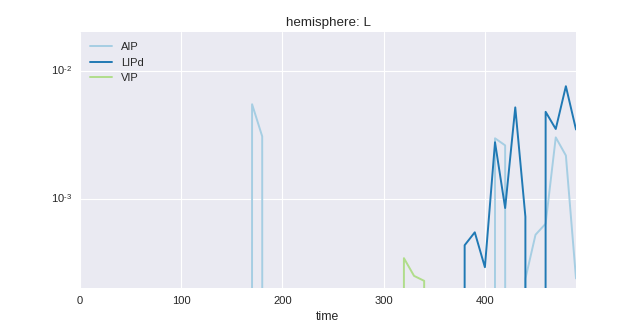

<IPython.core.display.Javascript object>


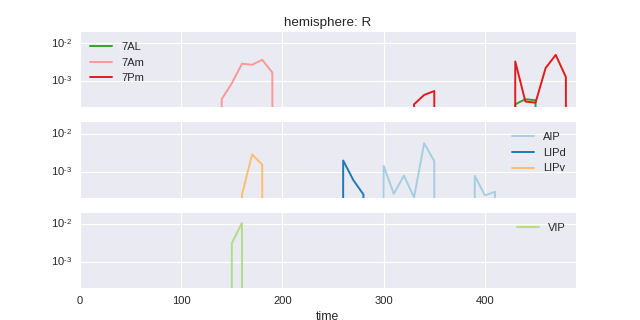

In [17]:
print(r_name)

region = 'superior parietal'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.region.apply(lambda s: s.startswith(region))]), 
                    [threshold, ylims[measure]], logy=logy[measure])

### clusters associated with a particular area

dot_x


<IPython.core.display.Javascript object>


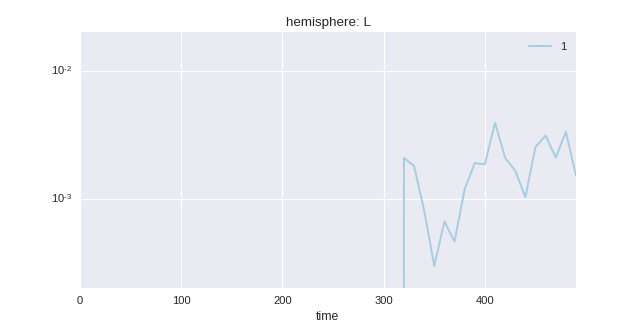

<IPython.core.display.Javascript object>


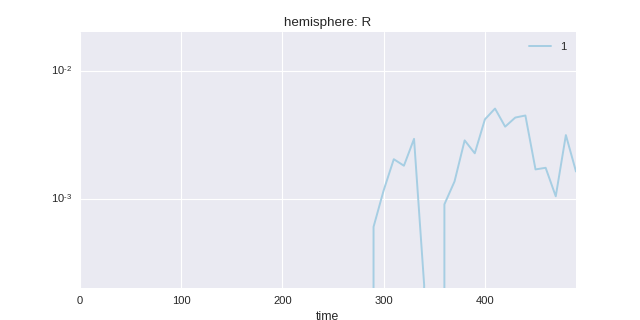

In [18]:
print(r_name)

# put the full area name in underscores such as '_1_' to match exactly
area = '_1_'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.label.apply(lambda s: s.find(area)>0)]), 
                    [threshold, ylims[measure]], logy=logy[measure])

### clusters with reliable effect around a particular time

dot_x


<IPython.core.display.Javascript object>


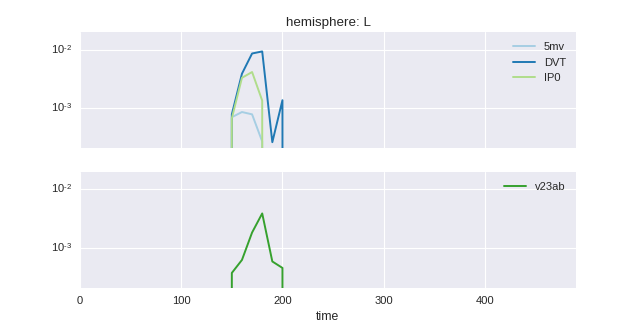

<IPython.core.display.Javascript object>


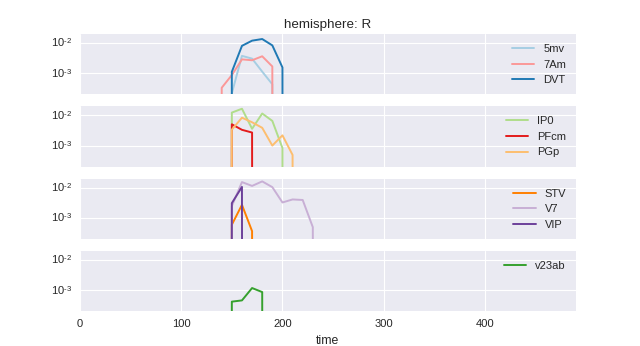

In [19]:
print(r_name)

time = 150

sv.show_timecourses(get_cluster_tcs(r_clusters[(time >= r_clusters.start_t) & (time <= r_clusters.end_t)]), 
                    [threshold, ylims[measure]], logy=logy[measure])